In [1]:
import os
import sys
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from scipy import stats
import pandas as pd
import math

proj_dir = os.path.join('..','..')
data_dir = os.path.join(proj_dir,'data','analysis')
int_dir = os.path.join(data_dir,'interim')
raw_dir = os.path.join(data_dir,'raw')
ext_dir = os.path.join(data_dir,'external')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')
tab_dir = os.path.join(proj_dir,'reports','tidal_melting','tables')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

tools_dir = os.path.join(src_dir,'tools')
sys.path.append(tools_dir)

from visualization.shiftedColorMap import shiftedColorMap
from visualization.plot_map import *
from log_progress import log_progress
from calc_antarctic_mass_loss import calc_antarctic_mass_loss
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves

from rotate_vector_roms import rotate_vector_roms
#from calc_melt_frc import calc_ustar,calc_frc
#from make_grd_dV import make_grd_dV

%load_ext autoreload
%autoreload 2
#%aimport tools.make_masks

In [2]:
file_path = os.path.join(data_dir,'raw','waom4','ocean_avg_0009_avg.nc')
tides = xr.open_dataset(file_path).squeeze()

file_path = os.path.join(data_dir,'raw','waom4_nt','ocean_avg_0009_avg.nc')
no_tides = xr.open_dataset(file_path).squeeze()

grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)
#grd = make_grd_dV(grd,tides.zeta)

shelves_masks_path = os.path.join(int_dir,'shelves4.npy') 
shelves = np.load(shelves_masks_path,allow_pickle=True).item()
shelves = {k: v for k, v in shelves.items() if v['mask'].any()}

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][1050:1140,95:113] = True

grd.mask_rho[570:610,1030:1140] = False

s2a = 365.25*24*3600

# Melting

In [5]:
def make_is_avg(da):
    ser = pd.Series()
    for k,v in log_progress(shelves.items(),every=2):
        dA = (grd.pm*grd.pn)**-1
        weights = dA.where(v['mask'])/dA.where(v['mask']).sum()
        ser[k] = (da*weights).sum().values
    return ser.astype(float)

def make_avg_map(df,df_shelf=None,df_frame=None):
    
    v_map = np.zeros_like(grd.mask_rho)
    mask_map = np.zeros_like(v_map)
    
    for k,v in df.iteritems():
        v_map[shelves[k]['mask']]=v
        mask_map[shelves[k]['mask']]=1
    
    if isinstance(df_shelf,pd.Series):
        for k,v in df_shelf.drop('Total Antarctica').iteritems():
            mask = (mask_shelf[k] == 1) & (grd.zice == 0)
            v_map[mask]=v
            mask_map[mask]=1
            
    if isinstance(df_frame,pd.Series):
        mask_frame = np.ones_like(grd.mask_rho)
        mask_frame[50:-50,50:-50] = 0
        for k,v in df_frame.drop('Total Antarctica').iteritems():
            mask = (mask_sector[k] == 1) & (mask_frame == 1)
            v_map[mask]=v
            mask_map[mask]=1
  
    return xr.DataArray(v_map,dims=('eta_rho','xi_rho')).where(mask_map)

def get_vrange(da,vrange):
    if vrange==None:
        mean = da.mean(dim=da.dims)
        std = da.std(dim=da.dims)
        vmin=0-2*std
        vmax=0+2*std
    elif vrange=='sat':
        vmax = max(da.max(),np.abs(da.min()))
        vmin = -vmax
    else:
        vmax=vrange[1]
        vmin=vrange[0]

    return vmin,vmax

def plot_map(da,title,name,cbar_label,cmap,vrange=None,cb_ext='both',ls='xx-large',grd=grd,
             sel={'xi_rho':slice(72,1465),'eta_rho':slice(85,1300)},sb=False,secb=False,save=False,norm=None):
    if sel:
        da = da.isel(sel)
        grd = grd.isel(sel)
        
    vmin,vmax = get_vrange(da,vrange)
    
    plt.close()
    fig,ax = plt.subplots(figsize=(9,11))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6'))) 
    if norm==None:
        cp = da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar=False)
        ax.contourf(grd.mask_rho.where(da==0),colors=(('0.6','0.6','0.6')),alpha=0.75)
    else:
        cp = da.plot(ax=ax,cmap=cmap,add_colorbar=False,norm=norm)

    
    
    if sb:
        for key,data in log_progress(shelves.items(),name='shelves'):
               ax.contour(xr.DataArray(data['mask'],dims=('eta_rho','xi_rho')).isel(sel),
                          colors=('black'),linewidths=0.1)
    if secb:            
        for k,sec_mask in mask_sector.items():
            sec_mask.isel(sel).where((grd.mask_rho ==1)&(grd.zice==0.0)).plot.contour(colors=('black'),
                                                                                      linewidths=0.1,ax=ax)             
    ax.contour(grd.zice.where(grd.mask_rho==1), levels=['-0.1'], colors=('black'),linewidths=0.1)
    ax.contour(grd.mask_rho, colors=('black'),linewidths=0.1)
    
    cb = plt.colorbar(cp, ax=ax, orientation="horizontal", pad=0.01, extend=cb_ext)
    cb.set_label(label=cbar_label, size=ls)
    cb.ax.tick_params(labelsize=ls)    
    ax.set_title(title,fontsize=ls, weight='bold')
    fig.patch.set_facecolor('xkcd:white')
    plt.tight_layout()
    if save==True:
        plt.savefig(os.path.join(fig_dir,'map_'+name.replace('/','_')+'.png'),format='png',bbox_inches = "tight")
    elif save=='hr':
        plt.savefig(os.path.join(fig_dir,'map_'+name.replace('/','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")
    plt.show()

In [4]:
mT = make_is_avg(tides.m)
mNt = make_is_avg(no_tides.m)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


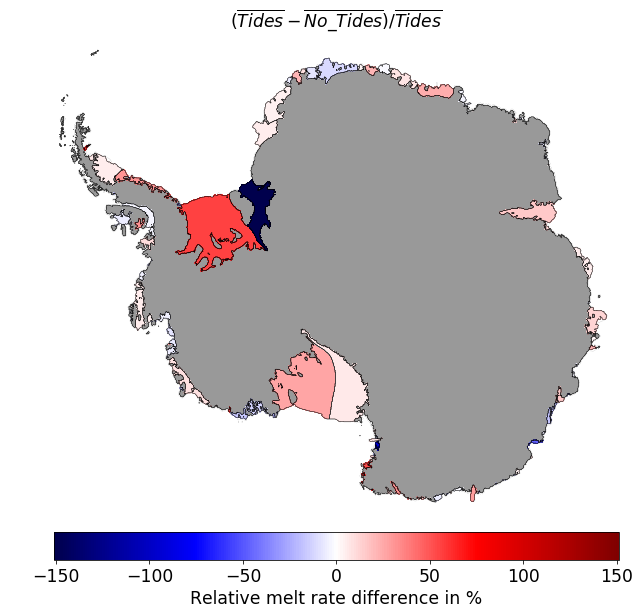

In [9]:
plot_map(make_avg_map((mT-mNt)/mT)*100,'$(\overline{Tides}-\overline{No\_Tides}) / \overline{Tides}$','relMeltDiffAvg','Relative melt rate difference in %',
        plt.cm.seismic,'sat',save='hr',cb_ext='neither',sb=True)

# Buttressing

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


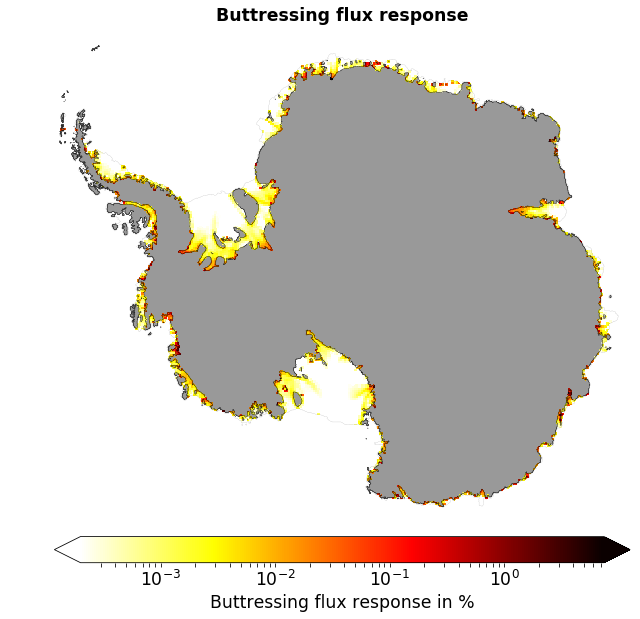

In [67]:
import scipy.io as sio
from scipy.interpolate import griddata

bfr_path = os.path.join(ext_dir,'reese','ButtressingFluxResponseNumbers.mat')
bfr = sio.loadmat(bfr_path)

mr=4
x,y = np.meshgrid(np.arange(-3000,3300+mr/2,mr/2),np.arange(-2700,2600+mr/2,mr/2))
x_rho = x[1::2,1::2]*1000
y_rho = y[1::2,1::2]*1000

bfr_rho = griddata((bfr['x'].flatten(),bfr['y'].flatten()),bfr['BFRN'].flatten(),(x_rho,y_rho),method='nearest')
bfr = xr.DataArray(bfr_rho,dims=('eta_rho','xi_rho')).where((grd.mask_rho ==1 ) & (grd.zice<0))

import matplotlib.colors as colors
plot_map(bfr.where(bfr>0),'Buttressing flux response','Buttressing flux response in %',
        "hot_r",save='hr',cb_ext='both',norm=colors.LogNorm(vmin=0,vmax=1))

In [83]:
rhoi=916
dA = (grd.pm*grd.pn)**-1
BFR = make_is_avg((tides.m-no_tides.m)*s2a*dA*rhoi*bfr)*10**-12

In [84]:
BFR.sort_values()

Totten              -0.002103
Ferrigno            -0.001473
Crosson             -0.000937
Frost               -0.000690
Marret              -0.000505
Moscow University   -0.000480
Pine Island         -0.000449
Dotson              -0.000314
WilmaRobertDowner   -0.000307
Fimbul              -0.000263
Deakin              -0.000236
Walgreen Coast 2    -0.000143
Ekstrom             -0.000117
Holmes              -0.000097
Swinburne           -0.000093
Thwaites            -0.000085
Shackleton          -0.000073
George VI           -0.000073
Stange              -0.000072
Mertz               -0.000069
Sulzberger          -0.000064
Philbin Inlet       -0.000042
Whittle             -0.000041
Lazarev             -0.000034
Cook                -0.000034
Withrow             -0.000033
Richter             -0.000031
Jelbart             -0.000031
Underwood           -0.000028
Williamson          -0.000021
                       ...   
Fisher               0.000002
LarsenA              0.000002
Abbot     

In [96]:
sheet_url = ('https://docs.google.com/spreadsheets/d/1VPcyQCssfLe4pndu5Psf1OumL4qHcZkvo0uQc3sRH2E/edit?usp=sharing')
csv_export_url = sheet_url.replace('edit?', 'export?gid=0&format=csv&')
glf = pd.read_csv(csv_export_url,index_col=0,na_values=['?','-',' '],skiprows=0)['Grounding line flux']
BFR_rel = BFR/glf 

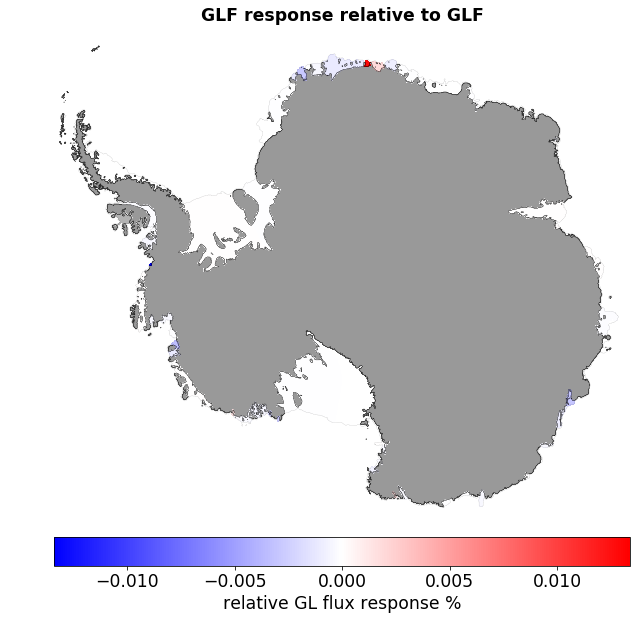

In [111]:
plot_map(make_avg_map(BFR_rel.dropna()*100),'GLF response relative to GLF','relative GL flux response %',
        "bwr",'sat',save='hr',cb_ext='neither')

# grid cell time series

In [17]:
file_path = os.path.join(data_dir,'raw','waom4_hr','ocean_avg_0010.nc')
tides_hr = xr.open_dataset(file_path).squeeze()

file_path = os.path.join(data_dir,'raw','waom4_hr_nt','ocean_avg_0010.nc')
no_tides_hr = xr.open_dataset(file_path).squeeze()

#grid_path = os.path.join(int_dir,'grd4_dV.nc')
#grd = xr.open_dataset(grid_path)

In [20]:
import matplotlib
from matplotlib.ticker import FormatStrFormatter

def plot_ts(eta,xi,title,save=False,ufac=False,Tfac=False):
    fig,ax1 = plt.subplots(figsize=(6,2))
    
    t = pd.date_range('2007-12-30T00:30:00',periods=720,freq='H')
    
    color='tab:blue'
    if ufac>1:
        ax1.plot(t,tides_hr.ustar[:,eta,xi]*100*ufac,color=color)
        exp = int(-math.log10(ufac))
        ax1.set_ylabel(f'u* [$10^{{{exp}}}$ cm/s]',color=color,size='xx-large')
    else:
        ax1.plot(t,tides_hr.ustar[:,eta,xi]*100,color=color)
        ax1.set_ylabel(f'u* [cm/s]',color=color,size='xx-large')
    
    ax1.tick_params(axis='y',labelcolor=color,labelsize='xx-large')  
    ax1.tick_params(axis='x',labelcolor='k',labelsize='xx-large')
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%i'))
    
    ax2 = ax1.twinx()
    color='tab:red'
    if Tfac>1:
        ax2.plot(t,tides_hr.Tstar[:,eta,xi]*Tfac,color=color)
        exp = int(-math.log10(Tfac))
        ax2.set_ylabel(f'T* [$10^{{{exp}}}$ $^{{\circ}}$C]',color=color,size='xx-large')
    else:
        ax2.plot(t,tides_hr.Tstar[:,eta,xi],color=color)
        ax2.set_ylabel(f'T* [$^{{\circ}}$C]',color=color,size='xx-large')
    
    ax2.tick_params(axis='y',labelcolor=color,labelsize='xx-large')  
    ax2.tick_params(axis='x',labelcolor='k',labelsize='xx-large')
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%i'))
    
    plt.title(title,size='xx-large',weight='bold')
    ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d/%b'))
 
    if save:
        plt.savefig(os.path.join(fig_dir,'ts_'+title.replace('/','_')+'.png'),dpi=300,format='png',bbox_inches = "tight")    
    plt.show()

In [101]:
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_ts(ts,title,ylabel,save=False,color='k',fil=False):
    ts = ts - ts.mean()
    ts = detrend(ts)
    if fil=='HP':
        ts = ts[12:-12] - moving_average(ts,25)
    if fil == 'LP':
        ts = moving_average(ts,25)

    fig,ax1 = plt.subplots(figsize=(3,2))
    #plt.gca().tick_params(axis='x',labelbottom='off')
    #plt.gca().tick_params(axis='y',labelleft='off')
    plt.axis('off')
    
    ax1.plot(ts,color=color)

    #ax1.tick_params(axis='y',labelcolor=color,labelsize='xx-large')  
    #ax1.tick_params(axis='x',labelcolor='k',labelsize='xx-large')
    #ax1.yaxis.set_major_formatter(FormatStrFormatter('%i'))
        
    
    #plt.title(title,size='xx-large',weight='bold')
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(fig_dir,'ts_'+title.replace('/','_')+'.png'),format='png',bbox_inches = "tight")    
    plt.show()

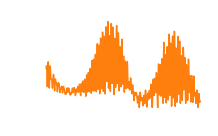

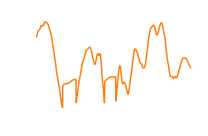

In [102]:
plot_ts(tides_hr.m[:,867,419],'m_tides','',True,color='tab:orange')
plot_ts(no_tides_hr.m[:,867,419],'m_noTides','',True,color='tab:orange')

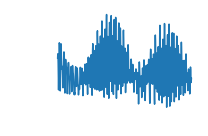

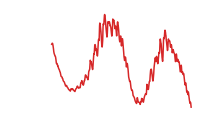

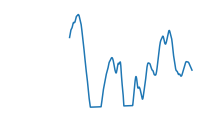

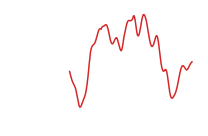

In [103]:
plot_ts(tides_hr.ustar[:,867,419],'u_tides','u*',True,color='tab:blue')
plot_ts(tides_hr.Tstar[:,867,419],'T_tides','u*',True,color='tab:red')
plot_ts(no_tides_hr.ustar[:,867,419],'u_noTides','u*',True,color='tab:blue')
plot_ts(no_tides_hr.Tstar[:,867,419],'T_noTides','u*',True,color='tab:red')

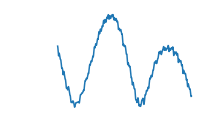

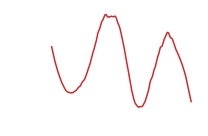

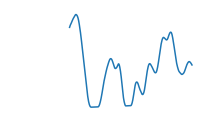

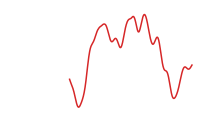

In [104]:
plot_ts(tides_hr.ustar[:,867,419],'u_tides_LP','u*',True,color='tab:blue',fil='LP')
plot_ts(tides_hr.Tstar[:,867,419],'T_tides_LP','u*',True,color='tab:red',fil='LP')
plot_ts(no_tides_hr.ustar[:,867,419],'u_noTides_LP','u*',True,color='tab:blue',fil='LP')
plot_ts(no_tides_hr.Tstar[:,867,419],'T_noTides_LP','u*',True,color='tab:red',fil='LP')

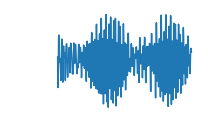

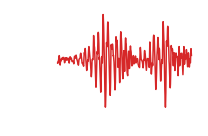

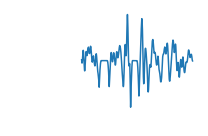

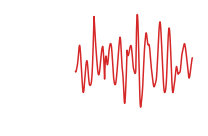

In [105]:
plot_ts(tides_hr.ustar[:,867,419],'u_tides_HP','u*',True,color='tab:blue',fil='HP')
plot_ts(tides_hr.Tstar[:,867,419],'T_tides_HP','u*',True,color='tab:red',fil='HP')
plot_ts(no_tides_hr.ustar[:,867,419],'u_noTides_HP','u*',True,color='tab:blue',fil='HP')
plot_ts(no_tides_hr.Tstar[:,867,419],'T_noTides_HP','u*',True,color='tab:red',fil='HP')

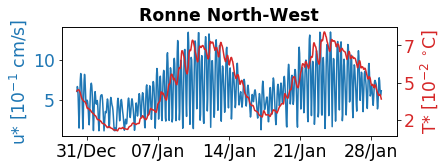

In [21]:
plot_ts(867,419,'Ronne North-West',False,10,100)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


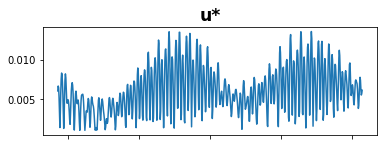